In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import re
import pickle
from wordcloud import WordCloud
from sklearn.metrics.pairwise import cosine_similarity
from gensim import corpora, models, similarities
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
import math
from time import time
from underthesea import word_tokenize
from operator import itemgetter
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('2k_data_Sep.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Feedback ID      2000 non-null   float64
 1   Lookup Text      2000 non-null   object 
 2   Question Text    2000 non-null   object 
 3   Feedback Type    2000 non-null   object 
 4   Feedback Result  2000 non-null   object 
 5   Human Feedback   2000 non-null   object 
 6   Lookup Image     2000 non-null   object 
 7   Question Image   2000 non-null   object 
dtypes: float64(1), object(7)
memory usage: 125.1+ KB


In [3]:
def clean_function(text):  
    #lowercase
    text = text.lower()
    
#     #xoá ký tự đặc biệt, ký tự không phải alphanumeric 
#     text = re.sub("[^a-z0-9àáạảãâầấậẩẫăằắặẳẵèéẹẻẽêềếệểễòóọỏõôồốộổỗơờớợởỡìíịỉĩùúụủũưừứựửữỳýỵỷỹđ]",' ', text)
    
#     #xoá leading zero
#     text = [e.lstrip('0') for e in text.split(' ')]
#     text = (' ').join(text)
    
    #replace extra spaces with single space
    text = re.sub(' +',' ',text)
    
#     #xoá khoảng trắng ở đầu và cuối mỗi câu
#     text = text.strip()
    
    #word tokenzie
    text = word_tokenize(text, format='text')
    return text

In [4]:
df['index_org'] = df.index

df['clean_lookup'] = df['Lookup Text'].map(lambda x: clean_function(x))
df['clean_question'] = df['Question Text'].map(lambda x: clean_function(x))

df['char_count_lookup'] = df['clean_lookup'].str.len()
df['word_count_lookup'] = df['clean_lookup'].str.split().str.len()
df['average_word_length_lookup'] = df['char_count_lookup'] / df['word_count_lookup']

df['char_count_question'] = df['clean_question'].str.len()
df['word_count_question'] = df['clean_question'].str.split().str.len()
df['average_word_length_question'] = df['char_count_question'] / df['word_count_question']

In [5]:
check_dup = df[['Lookup Text', 'Question Text']][df[['Lookup Text', 'Question Text']].duplicated()]
df = df.drop(check_dup.index)
df = df.reset_index(drop = True)
df.shape

(1962, 17)

In [6]:
mask1 = df['Human Feedback'] == 'MATCH'

df_pos = df[mask1].reset_index(drop = True)
df_pos

,Feedback ID,Lookup Text,Question Text,Feedback Type,Feedback Result,Human Feedback,Lookup Image,Question Image,index_org,clean_lookup,clean_question,char_count_lookup,word_count_lookup,average_word_length_lookup,char_count_question,word_count_question,average_word_length_question
0,4419.0,Đề số \( 1 . \)\n1. Tính\nb) \( \sqrt{25} \)\n...,b) \( \sqrt{25} \)\nc) \( \sqrt{-36} \)\na) \(...,NEGATIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/0398020...,https://s3.icankid.io/uploads/question/5a47b89...,1,đề số \ ( 1_._\ ) 1_._tính b ) \ ( \ sqrt { 25...,b ) \ ( \ sqrt { 25 }_\ ) c ) \ ( \ sqrt { - 3...,395,130,3.038462,400,131,3.053435
1,4420.0,1. Tính: \( \sqrt{\frac{25}{4}}+\left(\sqrt{\f...,Đề số \( 3 . \)\n1. Tính: \( \sqrt{\frac{25}{4...,POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/a81b075...,https://s3.icankid.io/uploads/question/2d3358a...,2,1_._tính : \ ( \ sqrt {_\ frac { 25 }_{ 4 } }_...,đề số \ ( 3 . \ ) 1_._tính : \ ( \ sqrt {_\ fr...,230,73,3.150685,248,81,3.061728
2,4432.0,25. Tìm giá trị x (làm tròn đến chữ số thập ph...,b) Canh BC.\n5. Tìm giá trị \( x \) (làm tròn ...,POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/71b3a3c...,https://s3.icankid.io/uploads/question/3c3ec9e...,7,25 . tìm giá_trị x ( làm tròn đến chữ_số thập_...,b ) canh bc . 5 . tìm giá_trị \ ( x \ ) ( làm ...,146,31,4.709677,160,41,3.902439
3,4443.0,Câu 6. Cho \( \frac{x-6}{1998}+\frac{x-4}{2000...,Câu 6. Cho \( \frac{x-6}{1998}+\frac{x-4}{2000...,POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/690df82...,https://s3.icankid.io/uploads/question/44a094e...,11,câu 6 . cho \ ( \ frac { x-6 }_{ 1998 }_+_\ fr...,câu 6 . cho \ ( \ frac { x-6 }_{ 1998 }_+_\ fr...,219,72,3.041667,218,72,3.027778
4,4446.0,Câu 7. Các giá trị của \( x \) thỏa mã \( \lef...,Câu 7. Các giá trị của \( x \) thỏa mãn \( \le...,POSITIVE,SKIP,MATCH,https://s3.icankid.io/uploads/question/539c341...,https://s3.icankid.io/uploads/question/eb404dc...,13,câu 7 . các giá_trị của \ ( x \ ) thỏa mã \ ( ...,câu 7 . các giá_trị của \ ( x \ ) thỏa_mãn \ (...,425,152,2.796053,426,151,2.821192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991,9955.0,3.36. Cho biết tích của hai số tự nhiên \( n \...,3.36. Cho biết tích của hai số tự nhiên \( n \...,POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/a08206d...,https://s3.stag.icankids.com.vn/uploads/questi...,1989,3.36 . cho biết tích của hai số tự_nhiên \ ( n...,3.36 . cho biết tích của hai số tự_nhiên \ ( n...,148,49,3.020408,156,52,3.000000
992,9967.0,"Câu 10: Trong hệ trục Oxy, cho \( \vec{u}=(-2 ...","Câu 18: Trong mặt phẳng tọa độ \( O x y \), ch...",NEGATIVE,SKIP,MATCH,https://s3.icankid.io/uploads/question/d34ea5b...,https://s3.icankid.io/uploads/question/d44ded4...,1992,"câu 10 : trong hệ trục oxy , cho \ ( \ vec {_u...",câu 18 : trong mặt_phẳng tọa_độ \ ( o x y \ ) ...,231,99,2.333333,242,99,2.444444
993,9973.0,6. Hai đoạn ống nước có chiều dài lần lượt là ...,6. Hai đoạn ống nước có chiều dài lần lượt là ...,POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/f60a06b...,https://s3.icankid.io/uploads/question/2740c6d...,1994,6 . hai đoạn ống nước có chiều dài lần_lượt là...,6 . hai đoạn ống nước có chiều dài lần_lượt là...,246,65,3.784615,243,64,3.796875
994,9978.0,"bao nhiêu phần kế hoạch?\n8. Vào tháng 6, giá ...","8. Vào tháng 6 , giá niêm yết một chiếc ti vi ...",POSITIVE,SKIP,MATCH,https://s3.icankid.io/uploads/question/9fee271...,https://s3.icankid.io/uploads/question/9363c3c...,1995,"bao_nhiêu phần kế_hoạch ? 8 . vào tháng 6 , gi...","8 . vào tháng 6 , giá niêm_yết một chiếc ti vi...",401,90,4.455556,375,86,4.360465


In [7]:
query = df_pos.iloc[0]['Lookup Text']
query = clean_function(query)
query

'đề số \\ ( 1_._\\ ) 1_._tính b ) \\ ( \\ sqrt { 25 }_\\ ) c ) \\ ( \\ sqrt { - 36 }_\\ ) a ) \\ ( \\ sqrt { 64 }_\\ ) e ) \\ ( \\_sqrt { ( - 5 ) ^ { 2 }_}_\\ ) d ) \\ ( \\ sqrt { 5 ^ { 2 }_}_\\ ) f ) \\ ( \\_frac { 2 } { 3_}_\\ sqrt { 81 } - \\_left ( - \\ frac { 3 }_{ 4 }_\\_right ) : \\ sqrt {_\\ frac { 9 }_{ 64 }_}_+_\\_left ( \\ frac {_\\_sqrt { 2 }_}_{_\\ sqrt { 3 }_}_\\_right ) ^_{ 0 } - ( \\ sqrt { 3 } ) ^ { 2 }_\\ )'

In [8]:
words_doc1 = set(query.lower().split())

In [9]:
words_doc2 = set(df_pos.iloc[0]['clean_question'].lower().split())

In [10]:
intersection = words_doc1.intersection(words_doc2)
intersection

{'(',
 ')',
 '-',
 '0',
 '2',
 '25',
 '3',
 '36',
 '3_}_\\',
 '4',
 '5',
 '64',
 '81',
 '9',
 ':',
 '\\',
 '\\_frac',
 '\\_left',
 '\\_sqrt',
 '^',
 '^_{',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'frac',
 'sqrt',
 '{',
 '{_\\',
 '{_\\_sqrt',
 '}',
 '}_\\',
 '}_\\_right',
 '}_{',
 '}_}_+_\\_left',
 '}_}_\\'}

In [11]:
union = words_doc1.union(words_doc2)
union

{'(',
 ')',
 '-',
 '0',
 '0_=_\\_frac',
 '1_._\\',
 '1_._tính',
 '2',
 '25',
 '3',
 '36',
 '3_}_\\',
 '3_}_\\_right',
 '4',
 '5',
 '64',
 '81',
 '9',
 ':',
 '\\',
 '\\_frac',
 '\\_left',
 '\\_sqrt',
 '^',
 '^_{',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'frac',
 'partial',
 's',
 'sqrt',
 'số',
 '{',
 '{_\\',
 '{_\\_sqrt',
 '}',
 '}_\\',
 '}_\\_right',
 '}_{',
 '}_{_\\',
 '}_}_+_\\_left',
 '}_}_\\',
 '}_}_\\_right',
 '}_}_{',
 '}_}_{_\\',
 'đề'}

In [12]:
jaccard_score = len(intersection) / len(union)
jaccard_score

0.76

In [ ]:
# def jaccard_search(query):
# #     #Load data
# #     df_product = pd.read_csv('data/product_names_clean.csv', index_col=0)
    
#     t0=time()
#     results = pd.DataFrame(columns=['question_text', 'j_score'])
    
#     query = clean_function(query)
#     words_doc1 = set(query.lower().split()) 
    
#     for i in range(df_pos.shape[0]):
#         words_doc2 = set(df_pos.iloc[i]['clean_question'].lower().split())

#         # Find the intersection of words list of doc1 & doc2
#         intersection = words_doc1.intersection(words_doc2)

#         # Find the union of words list of doc1 & doc2
#         union = words_doc1.union(words_doc2)

#         # Calculate Jaccard similarity score 
#         # using length of intersection set divided by length of union set
#         jaccard_score = len(intersection) / len(union)
#         result_dict = {
#                        'question_text':df_pos.iloc[i]['Question Text'],
#                        'j_score':jaccard_score}
#         result = pd.DataFrame({k: pd.Series(v) for k, v in result_dict.items()})
#         results = pd.concat([results,result], axis=0)
#     print('Time:',time()-t0)
#     return results.sort_values('j_score', ascending=False)[:5]

In [ ]:
jaccard_search(df_pos.iloc[81]['Lookup Text'])

In [13]:
def jaccard_search(query, top_result = 5, check_time = True):
#     #Load data
#     df_product = pd.read_csv('data/product_names_clean.csv', index_col=0)
    
    t0=time()
    results = pd.DataFrame(columns=['lookup_text', 'question_text', 'j_score', 'jc_word_count_question'])
    
    q = clean_function(query)
    words_doc1 = set(q.lower().split()) 
    
    for i in range(df_pos.shape[0]):
        words_doc2 = set(df_pos.iloc[i]['clean_question'].lower().split())

        # Find the intersection of words list of doc1 & doc2
        intersection = words_doc1.intersection(words_doc2)

        # Find the union of words list of doc1 & doc2
        union = words_doc1.union(words_doc2)

        # Calculate Jaccard similarity score 
        # using length of intersection set divided by length of union set
        jaccard_score = len(intersection) / len(union)
        result = pd.DataFrame({'lookup_text': query,
                               'question_text': [df_pos.iloc[i]['Question Text']],
                               'j_score': jaccard_score,
                               'jc_word_count_question': [df_pos.iloc[i]['word_count_question']]})
        results = pd.concat([results,result], axis=0).sort_values('j_score', ascending=False)[:top_result]
    if check_time:
        print('Time:',time()-t0)
    return results

In [ ]:
def jaccard_search_all(queries, check_time = True):
#     #Load data
#     df_product = pd.read_csv('data/product_names_clean.csv', index_col=0)
    
    t0=time()
    temp = pd.DataFrame(columns=['lookup_text', 'question_text', 'j_score'])
    results = pd.DataFrame(columns=['lookup_text', 'question_text', 'j_score'])
    for q in queries:
        query = clean_function(q)
        words_doc1 = set(query.lower().split()) 

        for i in range(df_pos.shape[0]):
            words_doc2 = set(df_pos.iloc[i]['clean_question'].lower().split())

            # Find the intersection of words list of doc1 & doc2
            intersection = words_doc1.intersection(words_doc2)

            # Find the union of words list of doc1 & doc2
            union = words_doc1.union(words_doc2)

            # Calculate Jaccard similarity score 
            # using length of intersection set divided by length of union set
            jaccard_score = len(intersection) / len(union)
            result = pd.DataFrame({'lookup_text': q,
                                   'question_text': [df_pos.iloc[i]['Question Text']],
                                   'j_score': jaccard_score})
            result_temp = pd.concat([temp,result], axis=0).sort_values('j_score', ascending=False)[:1]
        results = pd.concat([results,result_temp], axis=0)
    if check_time:
        print('Time:',time()-t0)
    return results

In [ ]:
jaccard_search(df_pos.iloc[0]['Lookup Text'])

In [ ]:
result_all = jaccard_search_all(df_pos['Lookup Text'])

In [ ]:
1095.7795822620392 / 60

In [ ]:
result_all

In [14]:
df_final = pd.DataFrame(columns = ['lookup_text', 'question_text', 'j_score', 'jc_word_count_question'])

queries = df_pos['Lookup Text']

t0 = time()
for q in queries:
    results = jaccard_search(q, check_time = False).head(1)
    df_final = pd.concat([df_final, results], axis = 0)
print('Jaccard search took: {:.2f} minutes.'.format((time() - t0) / 60))

Jaccard search took: 19.35 minutes.


In [15]:
df_final

,lookup_text,question_text,j_score,jc_word_count_question
0,Đề số \( 1 . \)\n1. Tính\nb) \( \sqrt{25} \)\n...,b) \( \sqrt{25} \)\nc) \( \sqrt{-36} \)\na) \(...,0.76,131
0,1. Tính: \( \sqrt{\frac{25}{4}}+\left(\sqrt{\f...,Đề số \( 3 . \)\n1. Tính: \( \sqrt{\frac{25}{4...,0.903226,81
0,25. Tìm giá trị x (làm tròn đến chữ số thập ph...,b) Canh BC.\n5. Tìm giá trị \( x \) (làm tròn ...,0.534884,41
0,Câu 6. Cho \( \frac{x-6}{1998}+\frac{x-4}{2000...,Câu 6. Cho \( \frac{x-6}{1998}+\frac{x-4}{2000...,0.891892,72
0,Câu 7. Các giá trị của \( x \) thỏa mã \( \lef...,Câu 7. Các giá trị của \( x \) thỏa mãn \( \le...,0.926829,151
...,...,...,...,...
0,3.36. Cho biết tích của hai số tự nhiên \( n \...,3.36. Cho biết tích của hai số tự nhiên \( n \...,0.88,52
0,"Câu 10: Trong hệ trục Oxy, cho \( \vec{u}=(-2 ...","Câu 18: Trong mặt phẳng tọa độ \( O x y \), ch...",0.607843,99
0,6. Hai đoạn ống nước có chiều dài lần lượt là ...,6. Hai đoạn ống nước có chiều dài lần lượt là ...,0.857143,64
0,"bao nhiêu phần kế hoạch?\n8. Vào tháng 6, giá ...","8. Vào tháng 6 , giá niêm yết một chiếc ti vi ...",0.921569,86


In [16]:
df_final.reset_index(drop = True, inplace = True)
df_final

,lookup_text,question_text,j_score,jc_word_count_question
0,Đề số \( 1 . \)\n1. Tính\nb) \( \sqrt{25} \)\n...,b) \( \sqrt{25} \)\nc) \( \sqrt{-36} \)\na) \(...,0.76,131
1,1. Tính: \( \sqrt{\frac{25}{4}}+\left(\sqrt{\f...,Đề số \( 3 . \)\n1. Tính: \( \sqrt{\frac{25}{4...,0.903226,81
2,25. Tìm giá trị x (làm tròn đến chữ số thập ph...,b) Canh BC.\n5. Tìm giá trị \( x \) (làm tròn ...,0.534884,41
3,Câu 6. Cho \( \frac{x-6}{1998}+\frac{x-4}{2000...,Câu 6. Cho \( \frac{x-6}{1998}+\frac{x-4}{2000...,0.891892,72
4,Câu 7. Các giá trị của \( x \) thỏa mã \( \lef...,Câu 7. Các giá trị của \( x \) thỏa mãn \( \le...,0.926829,151
...,...,...,...,...
991,3.36. Cho biết tích của hai số tự nhiên \( n \...,3.36. Cho biết tích của hai số tự nhiên \( n \...,0.88,52
992,"Câu 10: Trong hệ trục Oxy, cho \( \vec{u}=(-2 ...","Câu 18: Trong mặt phẳng tọa độ \( O x y \), ch...",0.607843,99
993,6. Hai đoạn ống nước có chiều dài lần lượt là ...,6. Hai đoạn ống nước có chiều dài lần lượt là ...,0.857143,64
994,"bao nhiêu phần kế hoạch?\n8. Vào tháng 6, giá ...","8. Vào tháng 6 , giá niêm yết một chiếc ti vi ...",0.921569,86


In [18]:
df_pos['search_result'] = df_final['question_text']
df_pos['j_score'] = df_final['j_score']
df_pos['jc_word_count_question'] = df_final['jc_word_count_question']

In [ ]:
# df_pos = df_pos[['Feedback ID', 'Lookup Text', 'Question Text', 
#                  'search_result', 'j_score', 'Feedback Type', 'Human Feedback',
#                  'Lookup Image', 'Question Image', 'clean_question']]

In [19]:
df_pos.head()

,Feedback ID,Lookup Text,Question Text,Feedback Type,Feedback Result,Human Feedback,Lookup Image,Question Image,index_org,clean_lookup,clean_question,char_count_lookup,word_count_lookup,average_word_length_lookup,char_count_question,word_count_question,average_word_length_question,search_result,j_score,jc_word_count_question
0,4419.0,Đề số \( 1 . \)\n1. Tính\nb) \( \sqrt{25} \)\n...,b) \( \sqrt{25} \)\nc) \( \sqrt{-36} \)\na) \(...,NEGATIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/0398020...,https://s3.icankid.io/uploads/question/5a47b89...,1,đề số \ ( 1_._\ ) 1_._tính b ) \ ( \ sqrt { 25...,b ) \ ( \ sqrt { 25 }_\ ) c ) \ ( \ sqrt { - 3...,395,130,3.038462,400,131,3.053435,b) \( \sqrt{25} \)\nc) \( \sqrt{-36} \)\na) \(...,0.76,131
1,4420.0,1. Tính: \( \sqrt{\frac{25}{4}}+\left(\sqrt{\f...,Đề số \( 3 . \)\n1. Tính: \( \sqrt{\frac{25}{4...,POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/a81b075...,https://s3.icankid.io/uploads/question/2d3358a...,2,1_._tính : \ ( \ sqrt {_\ frac { 25 }_{ 4 } }_...,đề số \ ( 3 . \ ) 1_._tính : \ ( \ sqrt {_\ fr...,230,73,3.150685,248,81,3.061728,Đề số \( 3 . \)\n1. Tính: \( \sqrt{\frac{25}{4...,0.903226,81
2,4432.0,25. Tìm giá trị x (làm tròn đến chữ số thập ph...,b) Canh BC.\n5. Tìm giá trị \( x \) (làm tròn ...,POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/71b3a3c...,https://s3.icankid.io/uploads/question/3c3ec9e...,7,25 . tìm giá_trị x ( làm tròn đến chữ_số thập_...,b ) canh bc . 5 . tìm giá_trị \ ( x \ ) ( làm ...,146,31,4.709677,160,41,3.902439,b) Canh BC.\n5. Tìm giá trị \( x \) (làm tròn ...,0.534884,41
3,4443.0,Câu 6. Cho \( \frac{x-6}{1998}+\frac{x-4}{2000...,Câu 6. Cho \( \frac{x-6}{1998}+\frac{x-4}{2000...,POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/690df82...,https://s3.icankid.io/uploads/question/44a094e...,11,câu 6 . cho \ ( \ frac { x-6 }_{ 1998 }_+_\ fr...,câu 6 . cho \ ( \ frac { x-6 }_{ 1998 }_+_\ fr...,219,72,3.041667,218,72,3.027778,Câu 6. Cho \( \frac{x-6}{1998}+\frac{x-4}{2000...,0.891892,72
4,4446.0,Câu 7. Các giá trị của \( x \) thỏa mã \( \lef...,Câu 7. Các giá trị của \( x \) thỏa mãn \( \le...,POSITIVE,SKIP,MATCH,https://s3.icankid.io/uploads/question/539c341...,https://s3.icankid.io/uploads/question/eb404dc...,13,câu 7 . các giá_trị của \ ( x \ ) thỏa mã \ ( ...,câu 7 . các giá_trị của \ ( x \ ) thỏa_mãn \ (...,425,152,2.796053,426,151,2.821192,Câu 7. Các giá trị của \( x \) thỏa mãn \( \le...,0.926829,151


In [20]:
mask2 = df_pos['Question Text'] != df_pos['search_result']

df_check = df_pos[mask2]
df_check.shape

(39, 20)

In [ ]:
demo = jaccard_search(df_pos.iloc[0]['Lookup Text'])
demo['question_text']

In [21]:
def check_wrong_results(indices):
    index_ = df_check.index.tolist()
    no_results = []
    top5_results = []
    for num in indices:
        df_results = jaccard_search(df_check.iloc[num]['Lookup Text'], check_time = False)
        top_results = df_results['question_text'].values
        if (df_check.iloc[num]['Lookup Text'] in top_results) or (df_check.iloc[num]['Question Text'] in top_results):
            top5_results.append(index_[num])
        else:
            no_results.append(index_[num])
    return top5_results, no_results

In [22]:
top5_result, no_result = check_wrong_results(list(range(0, len(df_check.index))))

In [23]:
print(len(top5_result))
print(len(no_result))

34
5


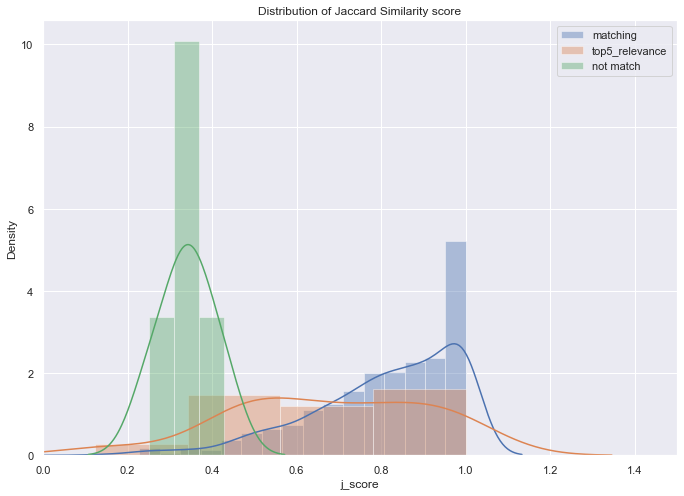

In [27]:
sb.set_theme()
plt.figure(figsize=(25 ,8))
plt.subplot(121)
sb.distplot(df_match.j_score, label = 'matching')
plt.subplot(121)
sb.distplot(df_top5.j_score, label = 'top5_relevance')
plt.subplot(121)
sb.distplot(df_no.j_score, label = "not match")
plt.xlim([0, 1.5])
plt.legend()
plt.title('Distribution of Jaccard Similarity score')
plt.show()

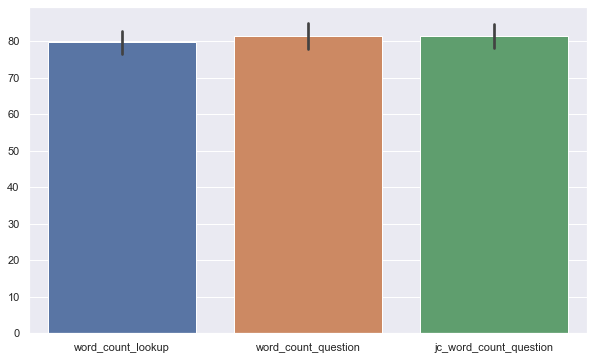

In [29]:
plt.figure(figsize=(10, 6))
sb.barplot(data = df_match[['word_count_lookup', 'word_count_question', 'jc_word_count_question']]);

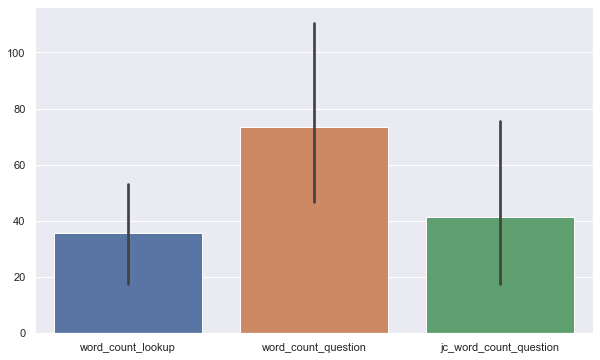

In [30]:
plt.figure(figsize=(10, 6))
sb.barplot(data = df_no[['word_count_lookup', 'word_count_question', 'jc_word_count_question']]);

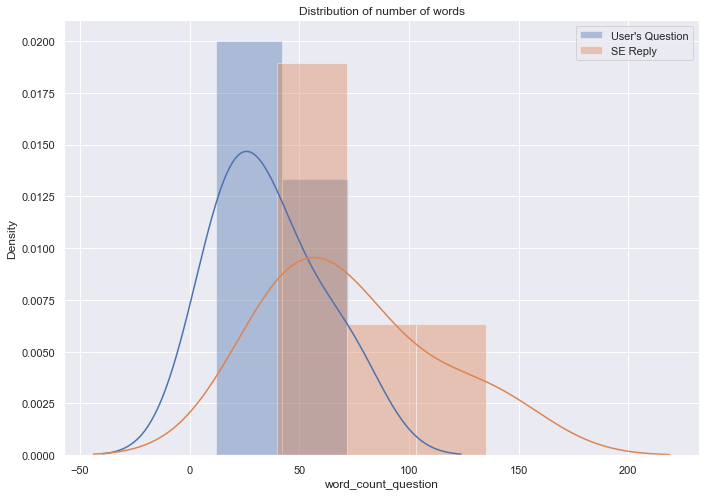

In [113]:
plt.figure(figsize=(25, 8))
plt.subplot(121)
sb.distplot(df_no.word_count_lookup, label = "User's Question")
plt.subplot(121)
sb.distplot(df_no.word_count_question, label = "SE Reply")
plt.legend()
plt.title('Distribution of number of words')
plt.show()

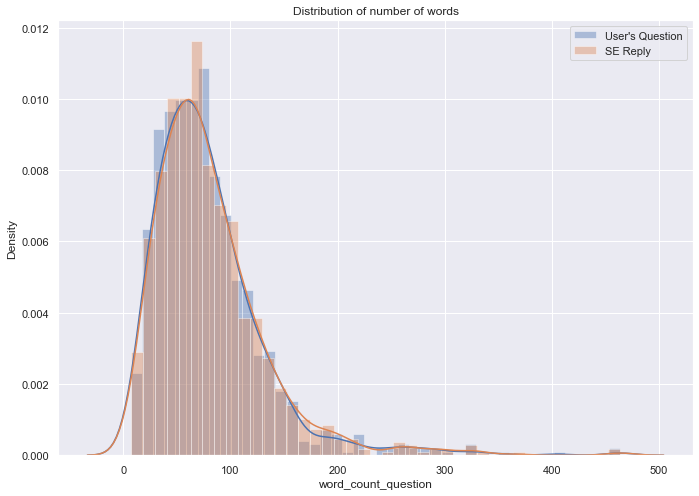

In [114]:
plt.figure(figsize=(25, 8))
plt.subplot(121)
sb.distplot(df_match.word_count_lookup, label = "User's Question")
plt.subplot(121)
sb.distplot(df_match.word_count_question, label = "SE Reply")
plt.legend()
plt.title('Distribution of number of words')
plt.show()

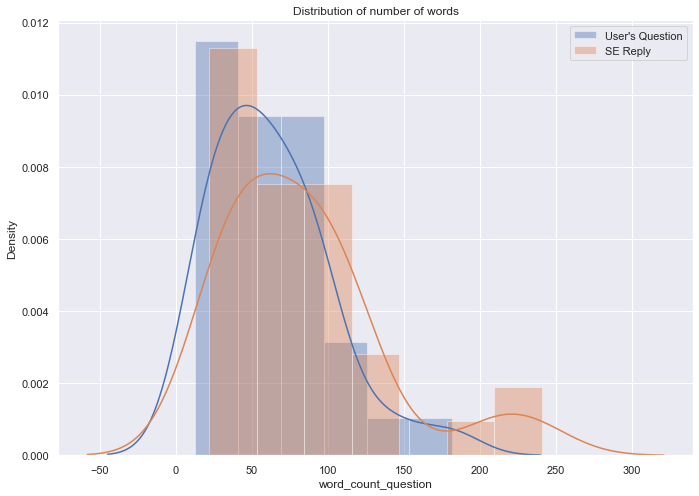

In [115]:
plt.figure(figsize=(25, 8))
plt.subplot(121)
sb.distplot(df_top5.word_count_lookup, label = "User's Question")
plt.subplot(121)
sb.distplot(df_top5.word_count_question, label = "SE Reply")
plt.legend()
plt.title('Distribution of number of words')
plt.show()

In [26]:
mask3 = df_pos['Question Text'] == df_pos['search_result']

df_match = df_pos[mask3]
df_match.shape

(957, 20)

In [24]:
df_no = df_pos.iloc[no_result, :]
df_no

,Feedback ID,Lookup Text,Question Text,Feedback Type,Feedback Result,Human Feedback,Lookup Image,Question Image,index_org,clean_lookup,clean_question,char_count_lookup,word_count_lookup,average_word_length_lookup,char_count_question,word_count_question,average_word_length_question,search_result,j_score,jc_word_count_question
454,6723.0,\( b_{Q_{h}^{h}} \) 7. Tìm \( x \) và y trên h...,"Tim x va y tren hinh 21 , biêt rång \( ABCD \)...",POSITIVE,SKIP,MATCH,https://s3.icankid.io/uploads/question/2dd1527...,https://s3.icankid.io/uploads/question/bcc04a4...,857,\ ( b_ { q_ { h }_^_{ h }_}_\ ) 7 . tìm \ ( x ...,"tim x va y tren hinh 21 , biêt rång \ ( abcd \...",138,45,3.066667,117,40,2.925000,"22 Hình thang \( A B C D \) có đáy \( A B, C D...",0.25,105
457,6742.0,\( B \dot{a} 21 \) duing theigg \( y=2 x-2018 \),Ба7 \( 2.21 \)\na) Xảc dịnh hệ số \( a \) và b...,NEGATIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/4ba3b92...,https://s3.icankid.io/uploads/question/3094e8e...,862,\ ( b \ dot { a } 21 \ ) duing theigg \ ( y_=_...,ба7 \ ( 2.21_\ ) a ) xảc dịnh hệ_số \ ( a_\ ) ...,58,19,3.052632,207,63,3.285714,"a) \( \frac{-1}{6}+0,75 \)",0.315789,16
514,7028.0,a) \( \sqrt{2 x-1}=7 \),Bài 4: (2 điểm) Giải các phương trình sau :\na...,NEGATIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/1a4e75c...,https://s3.icankid.io/uploads/question/eb3b8a9...,960,a ) \ ( \_sqrt { 2 x-1 } = 7_\ ),bài 4 : ( 2 điểm ) giải các phương_trình sau :...,32,12,2.666667,126,45,2.800000,a) \( (2 x-1) \cdot(x+2) \),0.428571,16
792,8705.0,Che \( \sin \alpha+\cos \alpha=a \). Tint \( \...,2: Cho biết \( \sin \alpha+\cos \alpha=a \). G...,NEGATIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/0cf6296...,https://s3.icankid.io/uploads/question/8894d0e...,1574,che \ ( \ sin \ alpha + \ cos \ alpha = a \ ) ...,2 : cho biết \ ( \ sin \ alpha + \ cos \ alpha...,95,31,3.064516,408,135,3.022222,\( 8 \sin 2 x-\cos 2 x+3 \sin x-\cos x-1=0 \),0.368421,23
802,8751.0,(1) Ve chising thang sautren aing 1 he thuc ta...,"Câu 15. \( (1,5 \) diểm).\na) Vẽ dổ thị của ha...",NEGATIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/da8811b...,https://s3.icankid.io/uploads/question/8d65716...,1590,( 1 ) ve chising thang sautren aing 1 he thuc ...,"câu 15 ._\ ( ( 1,5_\ ) diểm ) ._a ) vẽ dổ thị ...",203,72,2.819444,262,85,3.082353,26. Tính :\na) \( \left(2 x^{2}+3 y\right)^{3}...,0.340909,47


In [116]:
index_ = 457

In [117]:
df_pos.iloc[index_]['Lookup Text']

'\\( B \\dot{a} 21 \\) duing theigg \\( y=2 x-2018 \\)'

In [118]:
df_pos.iloc[index_]['Question Text']

'Ба7 \\( 2.21 \\)\na) Xảc dịnh hệ số \\( a \\) và b của hàm số \\( y=a x+b \\) biét đồ thị của hàm số là dưing thẳng song song vơi dương thẳng \\( y=2 x+2017 \\) va di qua diém \\( A(-1 ; 3) \\).'

In [119]:
ss = df_pos.iloc[index_]['search_result']
ss

'a) \\( \\frac{-1}{6}+0,75 \\)'

In [110]:
df_pos.iloc[index_]['Lookup Image']

'https://s3.icankid.io/uploads/question/da8811b0-3890-11ed-afcb-abad28552b30'

In [111]:
df_pos.iloc[index_]['Question Image']

'https://s3.icankid.io/uploads/question/8d657160-2761-11ed-8671-9785b1571c36'

In [112]:
df_pos.loc[df_pos['Question Text'] == ss]['Question Image'].values[0]

'https://s3.stag.icankids.com.vn/uploads/question/c2153940-9c6a-11ec-b48e-29da3875b0c3'

In [25]:
df_top5 = df_pos.iloc[top5_result, :]
df_top5

,Feedback ID,Lookup Text,Question Text,Feedback Type,Feedback Result,Human Feedback,Lookup Image,Question Image,index_org,clean_lookup,clean_question,char_count_lookup,word_count_lookup,average_word_length_lookup,char_count_question,word_count_question,average_word_length_question,search_result,j_score,jc_word_count_question
43,4615.0,1.4. Phát biểu mệnh đề đảo của mồi mệnh đề sau...,4. Phát biều mệnh đề đảo của mởi mệnh đề sau v...,POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/048f21c...,https://s3.icankid.io/uploads/question/2a5256c...,80,1.4 . phát_biểu mệnh_đề đảo của mồi mệnh_đề sa...,4 ._phát biều mệnh_đề đảo của mởi mệnh_đề sau ...,276,73,3.780822,283,78,3.628205,1.4. Phát biểu mệnh đề đảo của mỗi mệnh đề sau...,0.727273,78
103,4970.0,BAI TAPP\n1.1. Cho hai tập hợp:\n\[\nA =\{a ; ...,1.1. Cho hai tập họp:\n\[\nA =\{a ; b ; c ; x ...,POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/d0db61c...,https://s3.icankid.io/uploads/question/48867c2...,196,bai tapp 1.1 . cho hai tập_hợp : \_[_a_=_\_{_a...,1.1 . cho hai tập họp : \_[_a_=_\_{_a ; b ; c ...,272,78,3.487179,270,83,3.253012,1.1. Cho hai tập hợp:\n\[\nA =\{a ; b ; c ; x ...,0.877551,79
131,5123.0,Cov M Ha tḥp hop các só tư nhiên lón hơn 6 và ...,Luyẹ tạp 3\nGọi \( M \) là tập hợ các số tự nh...,NEGATIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/8a2684f...,https://s3.icankid.io/uploads/question/b89da74...,241,cov m ha tḥp hop các só tư_nhiên lón hơn 6 và ...,luyẹ tạp 3 gọi \ ( m \ ) là tập hợ các số tự_n...,95,24,3.958333,201,68,2.955882,Bài 5. a) Viết tập hợp các số tự nhiên \( A \)...,0.191489,84
136,5135.0,"1.2. Cho tập hợp\nTrong các số 3; 5; 6; 0;7, s...",1.2. Cho tập họp \( U=\{x \in N \mid x \) chia...,POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/8586a4c...,https://s3.icankid.io/uploads/question/8d522ad...,248,1.2 . cho tập_hợp trong các số 3 ; 5 ; 6 ; 0 ;...,1.2 . cho tập họp \ ( u =_\_{ x \ in n \ mid x...,124,33,3.757576,155,48,3.229167,1.2. Cho tập hợp\n\( U=\{x \in N \mid x \) chi...,0.5,53
157,5212.0,Baii 1.37.Hoàn thảnh bảng sau vào vở:\n\begin{...,1.37. Hoàn thành bảng sau vào vở:\n\begin{tabu...,POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/fdffd18...,https://s3.icankid.io/uploads/question/ff29d29...,281,baii 1.37 . hoàn thảnh bảng sau vào vở : \ beg...,1.37 . hoàn_thành bảng sau vào vở : \ begin { ...,318,98,3.244898,317,94,3.372340,1.37. Hoàn thành bảng sau vào vở:\n\begin{tabu...,0.589286,107
225,5626.0,khi hiem.\na) Khí hiếm náo có điêm đông đạc nh...,1.13. Bảng sau cho biết các điểm đông đặc và đ...,NEGATIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/4be5940...,https://s3.icankid.io/uploads/question/da73543...,434,khi hiem ._a ) khí_hiếm náo có điêm đông đạc n...,1.13 . bảng sau cho biết các điểm đông_đặc và ...,264,61,4.327869,1003,241,4.161826,3. Bảng sau cho biết các điểm đông đặc và điểm...,0.383333,71
271,5847.0,"BÀITẠPP\n3.1. Cho Hình 3.13, hãy kể tên các cặ...","BÀI TAAP\n×3.1. Cho Hình 3.13, hãy kể tên các ...",POSITIVE,SKIP,MATCH,https://s3.icankid.io/uploads/question/acd4f2c...,https://s3.icankid.io/uploads/question/18ff0f4...,514,"bàitạpp 3.1 . cho hình 3.13 , hãy kể tên các c...","bài taap × 3.1 . cho hình 3.13 , hãy kể tên cá...",60,14,4.285714,81,22,3.681818,"3.1. Cho Hình 3.13, hãy kể tên các cặp góc kề bù.",0.923077,13
272,5852.0,Luyen tepp 2\nTinh: \( 865279-45027 . \)\nYan ...,? \( ?+2895=2895+6789 . \)\n1.19. Tim số tự nh...,NEGATIVE,SKIP,MATCH,https://s3.icankid.io/uploads/question/3545dad...,https://s3.icankid.io/uploads/question/853f361...,515,luyen tepp 2 tinh : \ ( 865279 - 45027 ._\ ) y...,? \ ( ?_+ 2895 = 2895 + 6789 ._\ ) 1.19 . tim ...,513,147,3.489796,314,94,3.340426,1.17. Tinh:\na) \( 63548+19256 \);\nb) \( 1291...,0.609756,129
287,5937.0,Bài \( 1.1 \) (SGK trang 7): Cho hai tập hợp:\...,Bài 1.1 (SGK trang 7): Cho hai tập hơp:\n\[\nA...,POSITIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/4f4b4aa...,https://s3.icankid.io/uploads/question/364c0a7